# EchoB binary data: unpacking, cleaning, manipulating

It is possible to directly extract and manipulate the data output by the Telemed Echo Blaster (EchoB), rather than making use of software such as Articulate Assistant Advanced as an intermediary. We will go through this procedure below, extracting frames from the raw binary data using new utilities in the `ultratils` library - we can then play around with the resulting data, using not only `ultratils` but the additional image-processing utilities in `imgphon`.

Note that the method described in this notebook is required for legacy data collected using old versions of the EchoB client in `ultratils`. Future updates to `ultratils` will embed much of the information we gather from `.img.txt` metadata files in the header of the `.raw` file itself, analogous to how we handle `.bpr` data from Ultrasonix devices.

Some initial imports:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ultratils.rawreader import RawReader
% matplotlib inline

## Extracting a frame array

The ultrasound video data comes out of the EchoB as a continuous stream, with each successive frame's data concatenated to the end of the data already collected. So, successful extraction of a frame (or any frames at all) depends on knowing the dimensions of the output image array (in pixels). This will allow us to figure out how many bytes in the raw data a frame occupies.

Through trial and error, we've settled on 127 pixels wide by 1020 pixels tall, with one byte per pixel. The `RawReader` class in `ultratils` takes care of the rest.

The convenience function below grabs image metadata from the `.img.txt` files that are generated as part of the EchoB data-exporting process mediated by `ultratils`. (It is also stored here: https://gist.github.com/mfaytak/aa55973fb573448f3126080f1dc73365)

In [2]:
def read_echob_metadata(rawfile):
    '''
    Gather information about a .raw file from its .img.txt file. 
    For legacy .raw data without a header; if a header exists,
    use ultratils utilities.
    Inputs: a .raw file, which is assumed to have an .img.txt file
      with the same base name.
    Outputs:
      nscanlines, the number of scan lines ("width" of unconverted img)
      npoints, the number of pixels in each scan line ("height" of img)
      not_junk, the pixel index in each scan line where junk data begins
    '''
    mfile = os.path.splitext(rawfile)[0] + ".img.txt"
    mdict = {}
    with open(mfile, 'r') as mf:
        k = mf.readline().strip().split("\t")
        v = mf.readline().strip().split("\t")
        for fld,val in zip(k, v):
            mdict[fld] = int(val)
    
    nscanlines = mdict['Height']
    npoints = mdict['Pitch']
    junk = npoints - mdict['Width']
    
    return nscanlines, npoints, junk

Now, using `RawReader` from `ultratils`, let's extract the 31st frame in the data.

In [3]:
rf = './demo-files/2017-04-07T004356-0700.raw' # read in raw file
nscanlines, npoints, junk = read_echob_metadata(rf)
print(nscanlines, npoints, junk)

127 1020 36


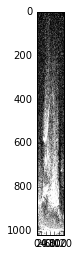

In [12]:
# TODO update ultratils and try to do this without the context manager
with RawReader(rf, nscanlines, npoints) as rdr:
    rd = rdr.get_frame(31)
    
plt.imshow(rd, cmap="Greys_r")

Some examination of the very top edge of the resulting image reveals that not all of the pixels allocated for data output by the EchoB actually contain the expected data: there is a visible discontinuity in the image's noise approximately 984 pixels from the base, which corresponds to a parameter saved in the metadata as `not_junk` above.

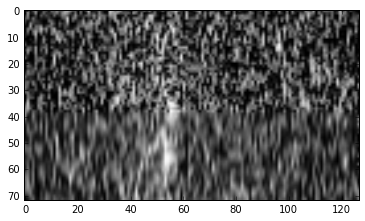

In [11]:
plt.imshow(rd[0:72,:], cmap="Greys_r") # note that we work from the top down with the indexing here

We can use the `junk` value (here, 36) output by `read_echob_metadata` to remove the junk data: simply read in the data starting at the row index given by `junk`.

(984, 127)

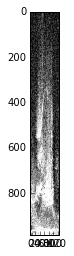

In [10]:
td = rd[junk:,:]
plt.imshow(td, cmap="Greys_r")
td.shape # note that the shape's long dimension is now the "Width" parameter in the .img.txt file

## Displaying to physical scale

Now that we have extracted a frame, we can see that it is not yet in the expected "fan" shape. This is a problem if we need the tongue contour to meaningfully correspond to the physical dimensions of the vocal tract. Enter `ultratils` and its fan-conversion utilities. The `Converter` class, once instantiated with a header containing image dimension information and some information on the ultrasound probe, can convert "rectangular" data like the frame above to the desired "fan" shape. Some information on the ultrasound probe has been determined through trial and error.

In [13]:
from ultratils.pysonix.scanconvert import Converter

class Header(object):
    def __init__(self):
        pass

class Probe(object):
    def __init__(self):
        pass
    
header = Header()
header.w = nscanlines     # "width" of image in terms of scan lines
header.h = npoints - junk # "height" of image in terms of pixels per scan line, excluding junk data at top (1020-36 = 984)
header.sf = 4000000       # magic number, sorry!

probe = Probe()
probe.radius = 10000    # based on '10' in transducer model number
probe.numElements = 128 # based on '128' in transducer model number
probe.pitch = 188       # best guess based on Ultrasonix C9-5/10 transducer, with modifications

# instantiate converter
conv = Converter(header, probe)

And with that, we can convert to:

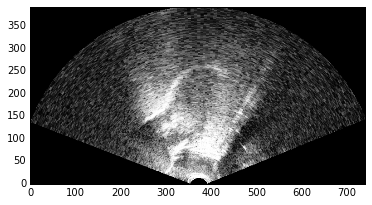

In [15]:
fd = conv.convert(np.flipud(td))
plt.imshow(fd, cmap = "Greys_r", origin="lower")

## Noise reduction with imgphon
This image has a large amount of speckle noise, which is characteristic of ultrasound imaging in general. We can apply a series of filtering operations from `imgphon` to reduce the speckle noise and emphasize the tongue contour. 

In [16]:
from imgphon import ultrasound as iph

First, we carry out an operation called speckle-reducing anisotropic diffusion (SRAD), which has been recognize for some time as a powerful means of removing speckle noise while preserving edge information in medical ultrasound imaging (Yu and Acton, 1999). This is contained in `srad` in `imgphon`; SRAD is best run on unconverted data (where the scan lines remain parallel to one another).

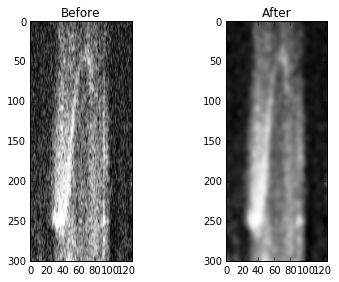

In [17]:
diff = iph.srad(td) # this is a bit slow at the moment; pardon the dust

plt.subplot(1,2,1)
plt.title("Before")
plt.imshow(td[300:600,:], cmap="Greys_r")
plt.subplot(1,2,2)
plt.title("After")
plt.imshow(diff[300:600,:], cmap="Greys_r")
plt.tight_layout()
plt.show() # note that the background, in particular, is a much more uniform dark color

Second, we perform a median filter followed by an edge enhancement operation on the unconverted (but trimmed) image. At the moment, this is packaged as a single step in `imgphon` as the function `clean_frame`.

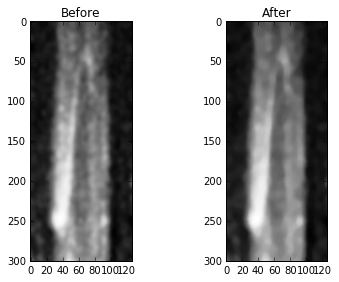

In [37]:
cleaned = iph.clean_frame(diff, median_radius=8, log_sigma=6) # TODO the all-zero behavior is back? can't replicate.

plt.subplot(1,2,1)
plt.title("Before")
plt.imshow(diff[300:600,:], cmap="Greys_r")
plt.subplot(1,2,2)
plt.title("After")
plt.imshow(cleaned[300:600,:], cmap="Greys_r")
plt.tight_layout()
plt.show()

Finally, we can use the converter we instantiated above to produce data rescaled to (approximately) physical size. Running `iph.clean_frame` on the converted image seems to produce better results since it sharpens the converted tongue contour.

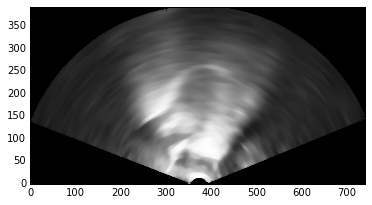

In [45]:
fan = conv.convert(np.flipud(diff))
cleaned = iph.clean_frame(fan, median_radius=10, log_sigma=6)
plt.imshow(cleaned, cmap="Greys_r", origin="lower")

## More data manipulation

Now that we can extract, convert, and filter any of the data from the original ultrasound video file, we can consider some more unusual ways to store and display the data. 

### Animated GIF

For instance, we can extract all frames, convert them, filter them, store them in an ndarray ...

In [30]:
length_of_array = 70
array_fans = np.empty([length_of_array] + list(fd.shape)) * np.nan
array_fans = array_fans.astype(np.uint8)
    
for idx in range(0,70):
    # TODO: replace this with rdr.data() method, which 
    with RawReader(rf, npoints, nscanlines) as rdr:
        rd = rdr.get_frame(idx)
    fd = conv.convert(rd)
    cleaned = clean_frame(fd)
    #cleaned = cleaned.astype(np.uint8)
    
    array_fans[idx,:,:] = np.flipud(cleaned)

... and make a GIF out of them. (The `gif` function below is defined as in __[this Gist](https://gist.github.com/nirum/d4224ad3cd0d71bfef6eba8f3d6ffd59)__ by GitHub user `nirum`.)

In [20]:
out = gif("sae-cleaned.gif", array_fans)


[MoviePy] Building file sae-cleaned.gif with imageio


100%|██████████| 140/140 [00:05<00:00, 25.05it/s]


Which gives us:
![sae-clean](./sae-clean.gif "sae-clean")

### M-mode ultrasound

We can also mimic M-mode ultrasound, which is a series of one-dimensional slices (one pixel wide) concatenated into an image that represents a time series. Each one-pixel-wide column in the unconverted ("rectangular") data is a scan line that points radially outward in the converted ("fan") data. Below, the line drawn vertically in the unconverted data at left ends up as a diagonal line in the converted data at right.

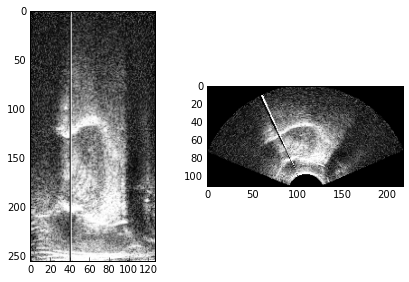

In [21]:
moddata = rawdata.copy()
moddata[:,40] = 0 # highlight a scan line - column 40
moddata[:,41] = 255 # for contrast - column 41

# plot unconverted data (L), converted data (R)
plt.subplot(1,2,1)
plt.imshow(np.flipud(moddata), cmap="Greys_r")
plt.subplot(1,2,2)
plt.imshow(np.flipud(conv.as_bmp(moddata)), cmap="Greys_r")
plt.tight_layout()
plt.show()

If we take these slices of the unconverted data and store them in an array ...

In [22]:
length_of_array = 140
scanline = rawdata[:,40]
array_scans = np.empty([length_of_array] + list(scanline.shape)) * np.nan
array_scans = array_scans.astype('uint8')
    
for idx in range(0,140):
    rawdata = get_frame(rf, idx, 127,255)
    scanline = rawdata[:,40]
    array_scans[idx,:] = scanline

... we can plot all of them as a time series. In the resulting image below, the brightest contour (between 100 and 150 on the Y axis) corresponds to the tongue blade's distance from the probe across the entire recording.

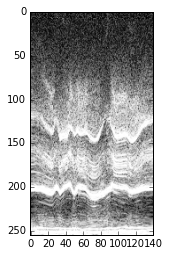

In [23]:
plt.imshow(np.rot90(array_scans), cmap="Greys_r")